In [1]:
from __future__ import print_function

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K




Using TensorFlow backend.


In [2]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = imread(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')













87916544/87910968 [==============================] - 1s 0us/step
Model loaded.


In [0]:
# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.0,
        'mixed3': 0.0,
        'mixed4': 0.0,
        'mixed5': 5.0,
    },
}


layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss = loss + coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss = loss + coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


Processing image shape (218, 466)
..Loss value at 0 : 0.68615854
..Loss value at 1 : 1.061559
..Loss value at 2 : 1.531367
..Loss value at 3 : 1.9978797
..Loss value at 4 : 2.408486
..Loss value at 5 : 2.7960105
..Loss value at 6 : 3.188888
..Loss value at 7 : 3.569911
..Loss value at 8 : 3.9486105
..Loss value at 9 : 4.3044114
..Loss value at 10 : 4.6568227
..Loss value at 11 : 5.02689
..Loss value at 12 : 5.423082
..Loss value at 13 : 5.7648687
..Loss value at 14 : 6.077632
..Loss value at 15 : 6.491167
..Loss value at 16 : 6.9062963
..Loss value at 17 : 7.3062735
..Loss value at 18 : 7.7076583
..Loss value at 19 : 8.2076025
Processing image shape (306, 653)
..Loss value at 0 : 1.1871978
..Loss value at 1 : 2.1474051
..Loss value at 2 : 3.0191529
..Loss value at 3 : 3.6977108
..Loss value at 4 : 4.300937
..Loss value at 5 : 4.957063
..Loss value at 6 : 5.5708966
..Loss value at 7 : 6.137111
..Loss value at 8 : 6.60308
..Loss value at 9 : 7.2731366
..Loss value at 10 : 7.7986054
..Los

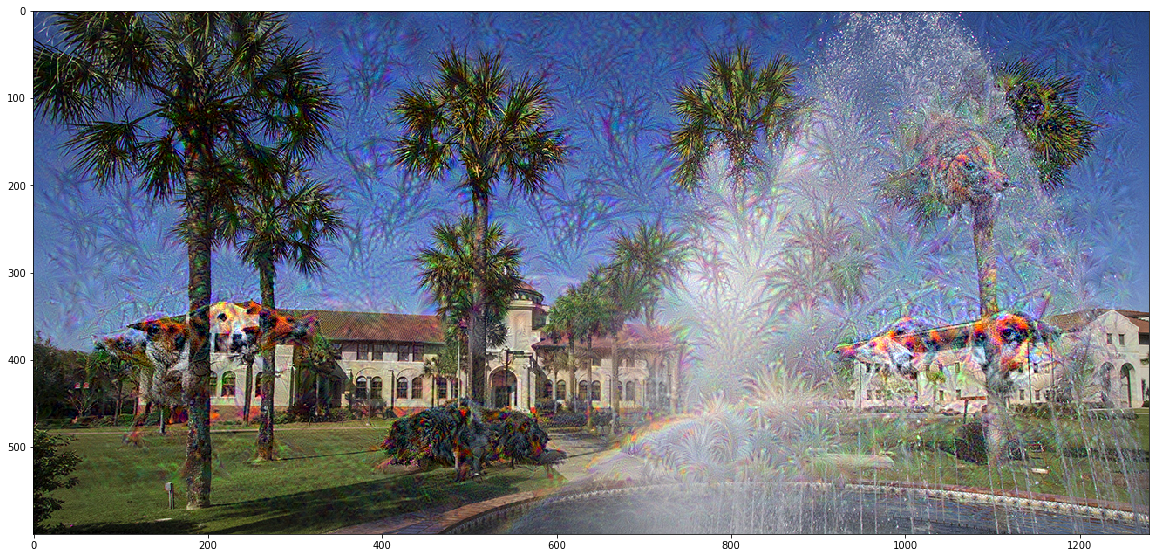

In [22]:

base_image_path = 'http://sgsc.edu/skins/userfiles/images/fountain%20web.jpg'


# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 4  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 20.

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

plt.figure(figsize=(20, 20))
plt.imshow(deprocess_image(img))

#save_img(result_prefix + '.png', deprocess_image(np.copy(img)))